In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import namedtuple

from onms_decoder import OnmsDecoder
from awgn import Awgn
from bpsk import Bpsk
from awgn_llr_adapter import AwgnLlrAdapter
%load_ext line_profiler

In [2]:
Settings = namedtuple('Settings', 'max_iter rejections_count snr_array')

In [15]:
#%%writefile simulation.py
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import namedtuple

from onms_decoder import OnmsDecoder
from awgn import Awgn
from bpsk import Bpsk
from awgn_llr_adapter import AwgnLlrAdapter

Settings = namedtuple('Settings', 'max_iter rejections_count snr_array')

def get_sigma(snr):
    return np.sqrt(10 ** (-snr/10)/2)

def simulate(settings, codeword, modulation, channel, decoder, decoder_adapter=None):
    
    simulations_count = len(settings.snr_array)
    fers = []
    is_max_iteration_reached = []
    sigmas = []
    
    for snr in settings.snr_array:
        
        sigma = get_sigma(snr)
        channel.sigma = sigma
        decoder_adapter.sigma = sigma
        
        errors_count = 0
        iterations_count = 0
        
        while (errors_count <= settings.rejections_count) and (iterations_count < settings.max_iter): 
            modulated = modulation.modulate(codeword);
            transmitted = channel.simulate(modulated);
            if decoder_adapter is not None:
                transmitted = decoder_adapter.adapt(transmitted)
            
            print(transmitted)
            decoded = decoder.decode(transmitted)
            errors_count += not decoded[0]
            iterations_count += 1
        
        fer = errors_count / iterations_count
        fers.append(fer)
        is_max_iteration_reached.append(settings.max_iter == iterations_count)
        sigmas.append(sigma)
        
    return {'snr': settings.snr_array.copy(),
            'sigmas' : sigma,
            'fers':fers,
            'is_max_iteration_reached':is_max_iteration_reached }

In [16]:
from scipy.io import loadmat
from scipy import sparse

H = np.array([[1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0]])
codeword = np.array([0, 0, 1, 1, 1, 0])

mat = loadmat('H_389_485.mat')
H_big = mat['Hb']
codeword_big = np.zeros(H_big.shape[1])

[ 3.27761196e+00  3.24549584e+00  1.21270713e+00  2.16499887e+00
  2.91373890e+00 -2.83404994e-01  1.09601991e+00 -1.07827160e+00
  4.33463749e+00  1.14626327e+00 -2.65910701e+00  2.93263876e-01
  1.84670230e-01  3.43697534e+00  6.45642658e-01  2.08096376e+00
  3.06552394e+00  1.81770011e+00  2.60593667e+00  3.43522972e+00
 -1.08958574e+00  3.76973263e+00 -1.43508159e+00  2.54609920e+00
  7.15677128e-01  1.70598297e+00 -2.00114907e-01  7.66701583e-01
 -6.68914055e-01 -5.49705868e-01  5.78603050e-01  2.22315971e+00
  2.09390888e+00  1.58825987e+00  5.05064076e+00 -2.16697334e-03
  3.74108786e+00  7.53328979e-01  2.89502852e+00  7.12979617e-01
  4.03508757e+00  3.06309265e-01 -1.20084433e-01  1.54367588e+00
  2.58210738e+00  2.92895991e+00  8.64561135e-01  2.96966012e+00
  2.93859488e-01  2.67228064e+00  3.87604366e+00  1.31819162e+00
  9.88864615e-01  1.16340069e+00  5.79559976e-01 -1.55660788e+00
  2.82892290e+00  1.22946757e+00  1.11105358e+00 -1.61732735e-02
 -1.20538430e-02  1.33967

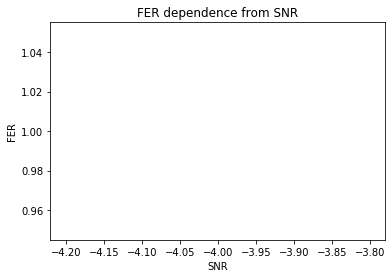

In [17]:

decoder = OnmsDecoder(H_big, multiplier=1, max_iteration=20);
channel = Awgn()
modulation = Bpsk()
adapter = AwgnLlrAdapter()

snr_min = -4
snr_max = -3
snr_step = 1
max_iterations_count = 1
fer_threshold = 1

settings = Settings(
    max_iterations_count,
    fer_threshold,
    np.arange(snr_min, snr_max, snr_step))

result = simulate(settings, codeword_big, modulation, channel, decoder, adapter)

print(result['sigmas'])
plt.plot(result['snr'], result['fers'])
plt.xlabel("SNR")
plt.ylabel("FER")
plt.title("FER dependence from SNR");

In [6]:
from simulation import simulate
%lprun -T lprof0 -f simulate simulate(settings,codeword_big,modulation,channel,decoder,adapter)


*** Profile printout saved to text file 'lprof0'. 


In [7]:
from onms_decoder import OnmsDecoder

%lprun -T lprof0 -f OnmsDecoder.decode simulate(settings,codeword_big,modulation,channel,decoder,adapter)


*** Profile printout saved to text file 'lprof0'. 


In [5]:
import numpy
from scipy.io import loadmat
from scipy import sparse

mat = loadmat('H_R1f6K76.mat')
print(mat)
H_tocsv = mat['H'].astype(int).todense()

numpy.savetxt("H_R1f6K76.csv", H_tocsv, fmt='%i', delimiter=",")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar 23 07:58:02 2020', '__version__': '1.0', '__globals__': [], 'H': <389x485 sparse matrix of type '<class 'numpy.float64'>'
	with 1991 stored elements in Compressed Sparse Column format>}


False